In [1]:
import os
import copy
import glob
import random
import time
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from fvcore.nn import FlopCountAnalysis, parameter_count_table


# =================================================================================
# 0. 재현성 / 유틸
# =================================================================================
def seed_everything(seed=42):
    """
    재현성 확보: Python, NumPy, PyTorch 모두 시드 고정
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id):
    """
    DataLoader의 worker마다 난수 고정
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [2]:
# =================================================================================
# 1. 데이터셋 (MHEALTH) - 23 채널 버전
# =================================================================================
class MHEALTHDataset(Dataset):
    """
    MHEALTH 데이터셋 로더 (23개 전체 채널 사용)
    - 각 subject의 .log 파일을 읽어 하나로 합친다.
    - class 0 (Null) 데이터는 제외한다.
    - 슬라이딩 윈도우 방식으로 데이터를 (C, T) 크기의 샘플로 만든다.
    """
    def __init__(self, data_dir, window_size=128, stride=64):
        self.window_size = window_size
        self.stride = stride
        
        # --- 📌 수정된 부분: 23개 전체 센서 채널 사용 ---
        feature_columns = [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
        ]
        
        all_dfs = []
        log_files = glob.glob(os.path.join(data_dir, "mHealth_subject*.log"))
        
        print(f"Found {len(log_files)} log files in {data_dir}")
        
        # MHEALTH 데이터셋의 실제 24개 컬럼 순서
        mhealth_columns = feature_columns + ['label']
        
        for file in log_files:
            df = pd.read_csv(file, sep='\t', header=None, names=mhealth_columns)
            all_dfs.append(df)
            
        full_df = pd.concat(all_dfs, ignore_index=True)
        
        # Null class (레이블 0) 제외
        full_df = full_df[full_df['label'] != 0].copy()

        # 레이블을 0부터 시작하도록 조정 (1~12 -> 0~11)
        full_df.loc[:, 'label'] = full_df['label'] - 1
        
        # 23개 피처 모두 사용
        X_df = full_df[feature_columns]
        y_series = full_df['label']
        
        self.X, self.y = self._create_windows(X_df, y_series)

        print(f"Loaded MHEALTH data: X shape={self.X.shape}, y shape={self.y.shape}")

    def _create_windows(self, X_df, y_series):
        windows = []
        labels = []
        
        start = 0
        while start + self.window_size <= len(X_df):
            end = start + self.window_size
            
            window_X = X_df.iloc[start:end].values
            window_y = y_series.iloc[end-1] 
            
            windows.append(window_X.T)
            labels.append(window_y)
            
            start += self.stride
            
        return np.array(windows, dtype=np.float32), np.array(labels, dtype=np.int32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]

In [3]:
# =================================================================================
# 2. CBAM (1D 버전)
# =================================================================================
class ChannelAttention1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = self.avg_pool(x).squeeze(-1)  # (B, C)
        max_out = self.max_pool(x).squeeze(-1)  # (B, C)

        avg_out = self.fc(avg_out)
        max_out = self.fc(max_out)

        out = (avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        scale = self.sigmoid(out)
        return x * scale


class TemporalAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)

        out = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        out = self.conv(out)                        # (B, 1, T)
        out = self.sigmoid(out)
        return x * out


class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction)
        self.temporal_att = TemporalAttention1D(kernel_size)

    def forward(self, x):
        # x : (B, C, T)
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x

In [4]:
# =================================================================================
# 3. Contrastive Prototype Loss
# =================================================================================
class ContrastivePrototypeLoss(nn.Module):
    """
    각 클래스의 prototype과 feature를 InfoNCE 방식으로 밀어붙이는 loss
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, prototypes, labels):
        """
        Contrastive Loss between features and prototypes

        Args:
            features: (B, D) - 샘플 특징
            prototypes: (N_class, D) - 클래스별 프로토타입
            labels: (B,) - 레이블

        Returns:
            loss: contrastive loss
        """
        # L2 normalize
        features = F.normalize(features, dim=1)
        prototypes = F.normalize(prototypes, dim=1)

        # cosine similarity
        logits = torch.matmul(features, prototypes.t()) / self.temperature  # (B, num_classes)

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)
        return loss

In [5]:
# =================================================================================
# 4. CrossFormer Block (Cross-Attn between tokens and learnable prototypes)
# =================================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self,
                 dim,
                 n_prototypes=6,
                 n_heads=4,
                 mlp_ratio=2.0, 
                 dropout=0.1,
                 initial_prototypes=None):
        super().__init__()
        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))
        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print(">>> [Main Model] Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print(">>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.")

        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim, hidden_dim), nn.GELU(), nn.Dropout(dropout),
                                 nn.Linear(hidden_dim, dim), nn.Dropout(dropout))
        self.proto_proj = nn.Sequential(nn.Linear(dim, dim), nn.GELU(), nn.Linear(dim, dim))

    def forward(self, x, return_proto_features=False, skip_cross_attention=False):
        B, T, C = x.shape
        attn_weights = None

        if not skip_cross_attention:
            normalized_prototypes = F.normalize(self.prototypes, dim=1)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)
            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out

        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out
        x = x + self.mlp(self.norm3(x))

        if return_proto_features:
            proto_features = x.mean(dim=1)
            proto_features = self.proto_proj(proto_features)
            return x, proto_features, attn_weights
        
        return x

In [6]:
# =================================================================================
# 5. 최종 HAR 모델: embedding + (CBAM) + CrossFormer + classifier
# =================================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    def __init__(self,
                 in_channels=9, 
                 seq_len=128,
                 embed_dim=64, 
                 reduced_dim=32,
                 n_classes=6, 
                 n_prototypes=6, 
                 n_heads=8,
                 kernel_size=7,
                 dropout=0.1,
                 temperature=0.07, 
                 initial_prototypes=None,
                 use_cbam=True,
                 use_crossformer=True,
                 use_contrast=True,
                 use_dim_reduction=False):
        super().__init__()
        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(embed_dim), nn.GELU(), nn.Dropout(dropout)
        )

        if self.use_cbam:
            self.cbam = CBAM1D(embed_dim, reduction=8, kernel_size=kernel_size)

        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim, n_prototypes=n_prototypes, n_heads=n_heads,
                mlp_ratio=2.0, dropout=dropout, initial_prototypes=initial_prototypes
            )
        else:
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim, nhead=n_heads, dim_feedforward=int(working_dim * 2),
                dropout=dropout, batch_first=True
            )

        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes)
        )
        
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)

    def forward(self, x, labels=None, return_contrast_loss=False):
        x = self.embedding(x)
        if self.use_cbam:
            x = self.cbam(x)
        x = x.transpose(1, 2).contiguous()
        if self.use_dim_reduction:
            x = self.dim_reduce(x)
        
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(x, return_proto_features=True)
            else:
                x = self.crossformer(x, return_proto_features=False)
        else:
            x = self.self_attn(x)
            
        if self.use_dim_reduction:
            x = self.dim_restore(x)
            
        x = x.transpose(1, 2).contiguous()
        x = self.pool(x).squeeze(-1)
        logits = self.classifier(x)
        
        if return_contrast_loss and self.use_contrast and proto_features is not None and labels is not None:
            contrast_loss = self.contrast_loss(proto_features, self.crossformer.prototypes, labels)
            return logits, contrast_loss
        return logits

In [7]:
# =================================================================================
# 6. 프로토타입 초기화: train data 평균 feature로 클래스별 prototype 만들기
# =================================================================================
def get_mean_prototypes(train_full_dataset, device, config):
    print("Calculating initial prototypes from mean features...")

    temp_model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'], 
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        n_classes=config['n_classes'],
        n_prototypes=config['n_prototypes'],
        use_cbam=True,
        use_crossformer=True, 
        use_contrast=False,
        use_dim_reduction=config['use_dim_reduction']
    ).to(device)

    temp_model.eval()

    temp_loader = DataLoader(train_full_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=0)
    all_features, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)
            x = temp_model.embedding(batch_x)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)
            x = x.transpose(1, 2).contiguous()
            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)
            x = temp_model.crossformer(x, skip_cross_attention=True)
            x = x.transpose(1, 2).contiguous()
            pooled_features = temp_model.pool(x).squeeze(-1)
            all_features.append(pooled_features.cpu())
            all_labels.append(batch_y.cpu())

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    working_dim = config['reduced_dim'] if config['use_dim_reduction'] else config['embed_dim']
    mean_prototypes = torch.zeros(config['n_classes'], working_dim)

    for i in range(len(mean_prototypes)):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            mean_prototypes[i] = torch.randn(working_dim)

    print(f"Initial prototypes calculated. Shape: {mean_prototypes.shape}")
    
    return mean_prototypes.to(device)

In [8]:
# =================================================================================
# 7. 학습/평가 루프
# =================================================================================
def train_epoch(model, dataloader, criterion, optimizer, device, use_contrast=True, contrast_weight=0.5):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_contrast_loss = 0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss + contrast_weight * contrast_loss
            total_contrast_loss += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_loss = total_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    avg_contrast_loss = total_contrast_loss / len(dataloader) if total_contrast_loss > 0 else 0
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1, all_preds, all_labels

In [9]:
# =================================================================================
# 8. 시각화 + 리포트 (cm, t-SNE 등)
# =================================================================================

# 라벨 이름 (index 0~5가 이 순서라고 가정)
ACTIVITY_LABELS = [
    'Standing still',       # 1
    'Sitting and relaxing', # 2
    'Lying down',           # 3
    'Walking',              # 4
    'Climbing stairs',      # 5
    'Waist bends forward',  # 6
    'Frontal elevation of arms', # 7
    'Knees bending (crouching)', # 8
    'Cycling',              # 9
    'Jogging',              # 10
    'Running',              # 11
    'Jump front and back'   # 12
]


def plot_classification_results(y_true, y_pred, save_path=None):
    """
    Confusion Matrix 시각화 (+ 선택적으로 파일 저장)
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=ACTIVITY_LABELS, digits=4))

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    print("\n" + "="*80)
    print("Normalized Confusion Matrix")
    print("="*80)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=ACTIVITY_LABELS, yticklabels=ACTIVITY_LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] Confusion matrix → {save_path}")
    plt.show()
    plt.close()


def visualize_tsne(model, dataloader, device, save_path=None):
    """
    모델의 마지막 특징(분류 직전 표현)을 t-SNE로 2D 투영해서 그린다.
    """
    print("\n" + "="*80)
    print("Generating t-SNE visualization (MODEL FEATURE)...")
    print("="*80)

    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Extracting features for t-SNE"):
            xb = xb.to(device)

            # 모델 내부에서 classifier 직전 feature까지 따라가기
            # (아래 로직은 네 notebook의 visualize_tsne() 구조 복원)
            x = model.embedding(xb)
            if model.use_cbam:
                x = model.cbam(x)
            x = x.transpose(1, 2)
            if model.use_dim_reduction:
                x = model.dim_reduce(x)
            # backbone
            if model.use_crossformer:
                x = model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=False
                )
            else:
                x = model.self_attn_layer(x)

            if model.use_dim_reduction:
                x = model.dim_restore(x)
            # GAP을 흉내내기 위한 mean pooling over seq
            pooled_features = x.mean(dim=1)  # (B, D_working)
            all_features.append(pooled_features.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=20,
        max_iter=2000,
        init='pca',
        learning_rate='auto'
    )
    proj = tsne.fit_transform(all_features)  # (N, 2)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [ACTIVITY_LABELS[l] for l in all_labels]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of Feature Space', fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(title='Activity', loc='upper right', fontsize=6, title_fontsize=7, labelspacing=0.2)
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] t-SNE (feature space) → {save_path}")

    plt.show()
    plt.close()


def visualize_tsne_raw(dataloader, device, save_path=None, max_points=2000):
    """
    모델을 거치기 전의 raw window (9채널 x 128길이)를
    그냥 flatten해서 t-SNE로 투영.
    """
    print("\n" + "="*80)
    print("Generating t-SNE visualization (RAW INPUT)...")
    print("="*80)

    all_raw = []
    all_labels = []

    for xb, yb in tqdm(dataloader, desc="Collecting raw windows for t-SNE"):
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]      # (M, C, T)
    y_sel = all_labels[idx]   # (M,)

    X_flat = X_sel.reshape(X_sel.shape[0], -1)  # (M, C*T)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=20,
        max_iter=2000,
        init='pca',
        learning_rate='auto'
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of RAW Input Space', fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(title='Activity', loc='upper right', fontsize=6, title_fontsize=7, labelspacing=0.2)
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] t-SNE (raw input) → {save_path}")

    plt.show()
    plt.close()

In [10]:
# =================================================================================
# 9. 모델 프로파일링: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model, sample_input, device, warmup=10, iters=50):
    """
    모델 구조/비용 측정:
    - 파라미터 수 (M)
    - FLOPs per sample (M)
    - 추론 시간 평균(ms)
    """
    model = model.to(device)
    model.eval()

    # params
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6

    # FLOPs
    with torch.no_grad():
        flops = FlopCountAnalysis(model, (sample_input.to(device),))
        flops_m = flops.total() / 1e6  # million FLOPs

    # inference time
    with torch.no_grad():
        # 워밍업: GPU/CPU 캐시 안정화
        for _ in range(warmup):
            _ = model(sample_input.to(device))

        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }


def print_model_profile(stats_dict):
    print("==== Model Profile ====")
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=======================")

Device: cuda
Loading UCI HAR Dataset from: C://Users/park9/CBAM_HAR/MHEALTH/MHEALTHDATASET
Found 10 log files in C://Users/park9/CBAM_HAR/MHEALTH/MHEALTHDATASET
Loaded MHEALTH data: X shape=(5361, 23, 128), y shape=(5361,)
Train: 3216, Validation: 1072, Test: 1073
Calculating initial prototypes from mean features...
>>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.


Prototype Init: 100%|██████████| 26/26 [00:00<00:00, 78.61it/s]


Initial prototypes calculated. Shape: torch.Size([12, 64])

Training with config: {'DATA_DIR': 'C://Users/park9/CBAM_HAR/MHEALTH/MHEALTHDATASET', 'BATCH_SIZE': 128, 'EPOCHS': 100, 'SEED': 42, 'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 0.0001, 'embed_dim': 64, 'reduced_dim': 32, 'n_heads': 8, 'kernel_size': 7, 'dropout': 0.1, 'in_channels': 23, 'n_classes': 12, 'n_prototypes': 12, 'use_cbam': True, 'use_crossformer': True, 'use_contrast': True, 'use_dim_reduction': False, 'temperature': 0.05, 'contrast_weight': 0.25}
>>> [Main Model] Prototypes initialized with calculated mean features.
Parameters: 75,802


Epoch [010/100] TrainLoss=0.1312 TrainAcc=0.9807 ValAcc=0.9804


Epoch [020/100] TrainLoss=0.0579 TrainAcc=0.9928 ValAcc=0.9823


Epoch [030/100] TrainLoss=0.0307 TrainAcc=0.9953 ValAcc=0.9888


Epoch [040/100] TrainLoss=0.0213 TrainAcc=0.9978 ValAcc=0.9841


Epoch [050/100] TrainLoss=0.0555 TrainAcc=0.9879 ValAcc=0.9869


Epoch [060/100] TrainLoss=0.0112 TrainAcc=0.9994 ValAcc=0.9879


Epoch [070/100] TrainLoss=0.0188 TrainAcc=0.9991 ValAcc=0.9888


Epoch [080/100] TrainLoss=0.0086 TrainAcc=0.9997 ValAcc=0.9907


Epoch [090/100] TrainLoss=0.0107 TrainAcc=0.9997 ValAcc=0.9916


Epoch [100/100] TrainLoss=0.0089 TrainAcc=0.9997 ValAcc=0.9916

✓ Training Complete!
  Best Val Acc: 0.9916 @ epoch 85
  Final Test (Best-VAL ckpt): Acc=0.9897 | F1=0.9897

Classification Report
                           precision    recall  f1-score   support

           Standing still     1.0000    1.0000    1.0000        98
     Sitting and relaxing     0.9802    0.9900    0.9851       100
               Lying down     0.9894    0.9894    0.9894        94
                  Walking     1.0000    0.9904    0.9952       104
          Climbing stairs     0.9903    0.9903    0.9903       103
      Waist bends forward     0.9889    1.0000    0.9944        89
Frontal elevation of arms     1.0000    1.0000    1.0000        87
Knees bending (crouching)     0.9870    0.9870    0.9870        77
                  Cycling     0.9905    0.9905    0.9905       105
                  Jogging     1.0000    0.9691    0.9843        97
                  Running     0.9691    1.0000    0.9843        94


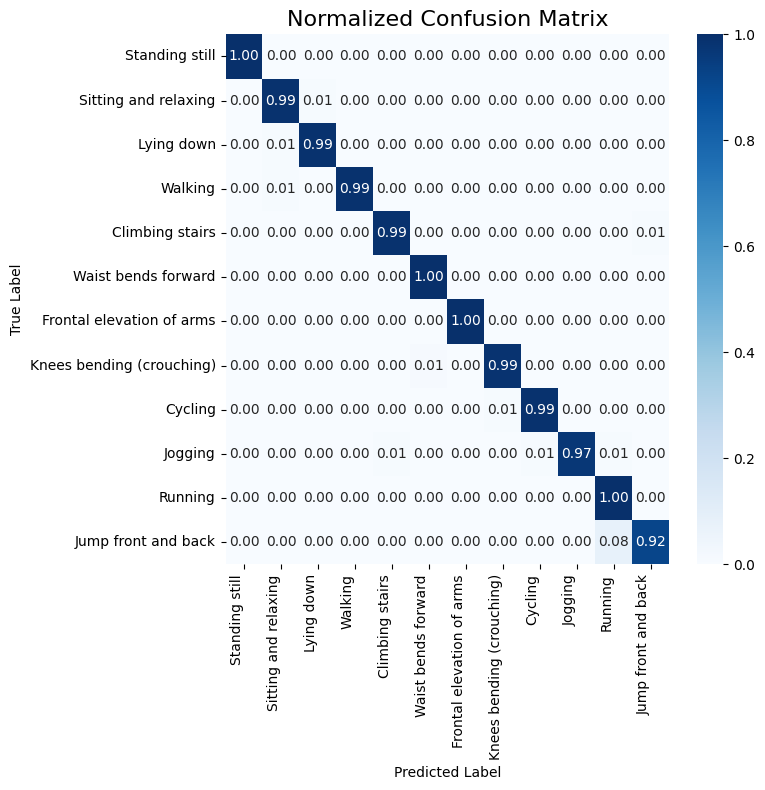


Generating t-SNE visualization (MODEL FEATURE)...


Extracting features for t-SNE: 100%|██████████| 9/9 [00:00<00:00, 118.43it/s]


[Saved] t-SNE (feature space) → tsne_feature.png


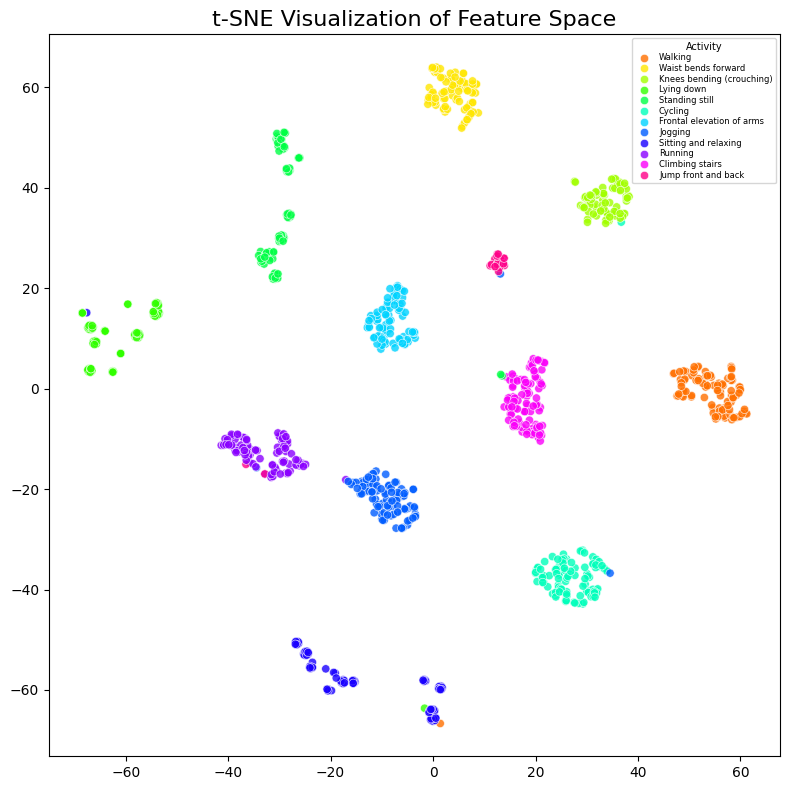


Generating t-SNE visualization (RAW INPUT)...


[Saved] t-SNE (raw input) → tsne_raw.png


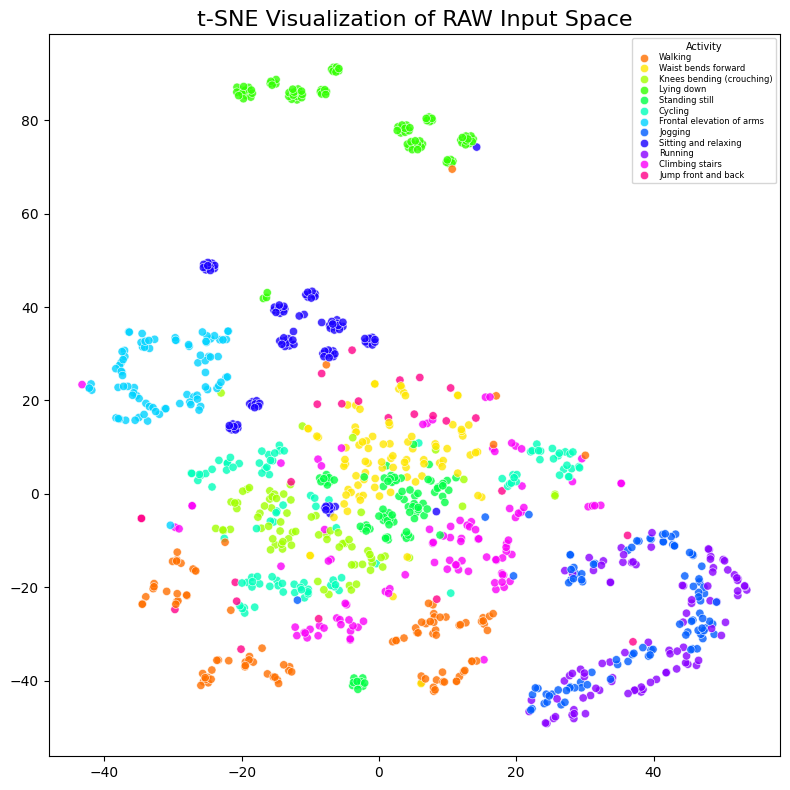

Unsupported operator aten::gelu encountered 3 time(s)
Unsupported operator aten::adaptive_avg_pool1d encountered 2 time(s)
Unsupported operator aten::adaptive_max_pool1d encountered 1 time(s)
Unsupported operator aten::add encountered 4 time(s)
Unsupported operator aten::sigmoid encountered 2 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::mean encountered 1 time(s)
Unsupported operator aten::linalg_vector_norm encountered 1 time(s)
Unsupported operator aten::clamp_min encountered 1 time(s)
Unsupported operator aten::expand_as encountered 1 time(s)
Unsupported operator aten::div encountered 2 time(s)
Unsupported operator aten::unflatten encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::_native_multi_head_attention encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward()

==== Model Profile ====
Parameters      : 0.0758 M
FLOPs / sample : 4.908 M
Infer Time     : 3.45 ms/sample

ALL PROCESSES COMPLETED!


In [11]:
# =====================================================================
# 10. 메인 실행
# =====================================================================
def main():
    # -----------------------------
    # 실험 설정 모음
    # -----------------------------
    config = {
        # 데이터/학습
        'DATA_DIR': 'C://Users/park9/CBAM_HAR/MHEALTH/MHEALTHDATASET',
        'BATCH_SIZE': 128,
        'EPOCHS': 100,
        'SEED': 42,
        'LEARNING_RATE': 5e-4,
        'WEIGHT_DECAY': 1e-4,

        # 모델 구조 (너 노트 기준)
        'embed_dim': 64,
        'reduced_dim': 32,
        'n_heads': 8,
        'kernel_size': 7,
        'dropout': 0.1,

        # !!! 데이터셋에 맞게 수정 !!!
        'in_channels': 23,       # MHEALTH에서 선택한 채널 수
        'n_classes': 12,        # MHEALTH 클래스 수 (Null 제외)
        'n_prototypes': 12,     # n_classes와 동일하게 설정

        # 구성 스위치
        'use_cbam': True,
        'use_crossformer': True,
        'use_contrast': True,
        'use_dim_reduction': False,

        # Loss 관련
        'temperature': 0.05,
        'contrast_weight': 0.25,
    }

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed_everything(config['SEED'])

    print(f"Device: {DEVICE}")
    print(f"Loading UCI HAR Dataset from: {config['DATA_DIR']}")

    # -----------------------------
    # 데이터셋 준비 / split
    # -----------------------------
    full_dataset = MHEALTHDataset(config['DATA_DIR']) # UCIHARDataset -> MHEALTHDataset

    # Train / Validation / Test 스플릿 (예: 60/20/20)
    total_size = len(full_dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(config['SEED'])
    )

    # train_full_dataset 대신 train_dataset을 프로토타입 초기화에 사용
    # (검증/테스트 데이터를 보지 않고 순수 학습 데이터만 사용하기 위함)
    train_full_dataset_for_proto = train_dataset 

    print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    g = torch.Generator().manual_seed(config['SEED'])
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0
    )

    # -----------------------------
    # 프로토타입 초기화
    # -----------------------------
    initial_prototypes = get_mean_prototypes(train_full_dataset_for_proto, DEVICE, config)

    print("\n" + "="*80)
    print(f"Training with config: {config}")
    print("="*80)

    # -----------------------------
    # 모델 생성
    # -----------------------------
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        seq_len=128,
        n_classes=config['n_classes'],
        n_prototypes=config['n_prototypes'],
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'],
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        temperature=config['temperature'],
        initial_prototypes=initial_prototypes,
        use_cbam=config['use_cbam'],
        use_crossformer=config['use_crossformer'],
        use_contrast=config['use_contrast'],
        use_dim_reduction=config['use_dim_reduction']
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")

    # -----------------------------
    # optimizer / scheduler / criterion
    # -----------------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['LEARNING_RATE'],
        weight_decay=config['WEIGHT_DECAY']
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['EPOCHS']
    )

    # -----------------------------
    # 학습 루프
    # -----------------------------
    history = []
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    for epoch in range(config['EPOCHS']):
        train_results = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            DEVICE,
            use_contrast=config['use_contrast'],
            contrast_weight=config['contrast_weight']
        )
        val_results = evaluate(model, val_loader, criterion, DEVICE)
        scheduler.step()

        train_loss, train_ce, train_contrast, train_acc, train_f1 = train_results
        val_loss, val_acc, val_f1, _, _ = val_results

        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
        })

        # best ckpt 추적
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1:03d}/{config['EPOCHS']:03d}] "
                f"TrainLoss={train_loss:.4f} "
                f"TrainAcc={train_acc:.4f} "
                f"ValAcc={val_acc:.4f}"
            )

    # -----------------------------
    # 최종 테스트 (best 상태로)
    # -----------------------------
    assert best_state is not None, "best_state is None (no epochs?)"
    model.load_state_dict(best_state)

    test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
        model, test_loader, criterion, DEVICE
    )

    print(f"\n✓ Training Complete!")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(f"  Final Test (Best-VAL ckpt): Acc={test_acc:.4f} | F1={test_f1:.4f}")

    # -----------------------------
    # 시각화 + 저장
    # -----------------------------
    plot_classification_results(
        test_labels,
        test_preds,
        save_path="confusion_matrix.png"
    )

    visualize_tsne(
        model,
        test_loader,
        DEVICE,
        save_path="tsne_feature.png"
    )

    visualize_tsne_raw(
        test_loader,
        DEVICE,
        save_path="tsne_raw.png"
    )

    # -----------------------------
    # 모델 프로파일링
    # -----------------------------
    dummy_input = torch.randn(1, config['in_channels'], 128)  # (B=1, C=12, T=128)
    stats = profile_model(model, dummy_input, DEVICE)
    print_model_profile(stats)

    print("\n" + "="*80)
    print("ALL PROCESSES COMPLETED!")
    print("="*80)


if __name__ == "__main__":
    main()